<a href="https://colab.research.google.com/github/Karthick47v2/speech-emotion-classifier/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_mfcc =np.load('drive/MyDrive/SER/X_mfcc.npy')
X_mel = np.load('drive/MyDrive/SER/X_mel.npy')
y = np.load('drive/MyDrive/SER/y.npy')

In [4]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_mel, y_encoded, random_state=42, test_size=0.1)

In [6]:
x_train.shape

(1296, 128, 200)

In [7]:
n_rows = x_train.shape[1]
n_cols = x_train.shape[2]
n_channels = 1

x_train = x_train.reshape(x_train.shape[0], n_rows, n_cols, n_channels)
x_test = x_test.reshape(x_test.shape[0], n_rows, n_cols, n_channels)

In [ ]:
## MFCC
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer="he_normal", input_shape=(n_rows, n_cols, n_channels), activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(units=8, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=1e-3))

n_epochs = 200
batch_size = 128

checkpoint = keras.callbacks.ModelCheckpoint(filepath='mfcc-model', 
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[checkpoint], verbose=1)

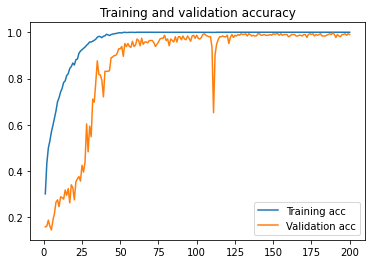

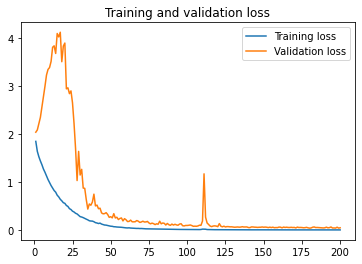

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# test
model = keras.models.load_model('mfcc-model')

In [ ]:
TESS_X_mfcc =np.load('drive/MyDrive/SER/TESS_X_mfcc.npy')
SAVEES_X_mfcc = np.load('drive/MyDrive/SER/SAVEES_X_mfcc.npy')
TESS_y = np.load('drive/MyDrive/SER/TESS_y.npy')
SAVEES_y = np.load('drive/MyDrive/SER/SAVEES_y.npy')

In [ ]:
le.fit(y)
TESS_y_encoded = to_categorical(le.transform(TESS_y))
# SAVEES_y_encoded = to_categorical(le.transform(SAVEES_y))

In [ ]:
y_preds = model.predict(TESS_X_mfcc)
y_hat = np.argmax(y_preds, axis=1)
y_true = np.argmax(TESS_y_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_true, y_hat)
cm

array([[  0,  13,   0,  73,   0,   0, 314,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   3,   3,   8,  15,   8, 361,   2],
       [  0,  81,   0, 139,   0,   0, 180,   0],
       [  0,   0,   8,  10,   6,   0, 376,   0],
       [  0,   0,   2,  20,  30,  16, 332,   0],
       [  0,  32,   0,  15,   0,   0, 353,   0],
       [  0,   7,   1,   6,   0,   5, 378,   3]])

In [72]:
## MEL
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer="he_normal", input_shape=(n_rows, n_cols, n_channels), activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Dense(units=8, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=1e-4))

n_epochs = 300
batch_size = 64

checkpoint = keras.callbacks.ModelCheckpoint(filepath='mel-model', 
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(x_test, y_test), callbacks=[checkpoint], verbose=1)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 126, 198, 16)      160       
                                                                 
 batch_normalization_60 (Bat  (None, 126, 198, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 63, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 61, 97, 16)        2320      
                                                                 
 batch_normalization_61 (Bat  (None, 61, 97, 16)       64        
 chNormalization)                                                
                                                     

In [28]:
# 16 16 16 - 56

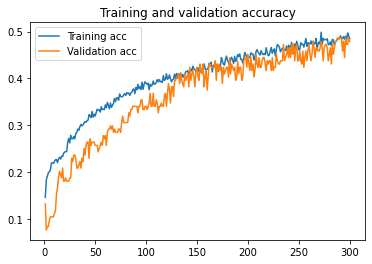

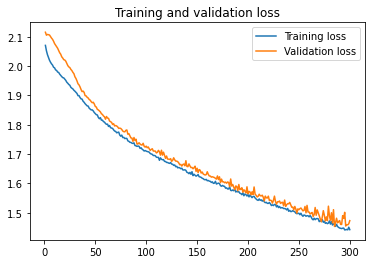

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [69]:
# test
model = keras.models.load_model('mel-model')

TESS_X_mel =np.load('drive/MyDrive/SER/TESS_X_mel.npy')
# SAVEES_X_mel = np.load('drive/MyDrive/SER/SAVEES_X_mel.npy')
TESS_y = np.load('drive/MyDrive/SER/TESS_y.npy')
# SAVEES_y = np.load('drive/MyDrive/SER/SAVEES_y.npy')

le.fit(y)
TESS_y_encoded = to_categorical(le.transform(TESS_y))
# SAVEES_y_encoded = to_categorical(le.transform(SAVEES_y))

y_preds = model.predict(TESS_X_mel)
y_hat = np.argmax(y_preds, axis=1)
y_true = np.argmax(TESS_y_encoded, axis=1)

cm = confusion_matrix(y_true, y_hat)

sum = 0

for i in range(cm.shape[0]):
  sum += cm[i,i]

print(len(y_preds))
print(sum / len(y_preds))

cm

2800
0.43357142857142855


array([[242, 158,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  4,   0, 116,   6,  99,   4,   2, 169],
       [ 95, 265,   4,  33,   2,   0,   1,   0],
       [  2,   0,  78,   5, 312,   3,   0,   0],
       [ 61,   0, 197,   7,  66,  67,   0,   2],
       [  0,   1,  97,   4, 134,   4, 125,  35],
       [  0,   0,  24,   0,  55,   1,   1, 319]])